In [101]:
from active_learning.learner.standard import Learner, get_classifier
from active_learning.weak_supervision.SelfTraining import SelfTraining
import argparse
import numpy as np
import copy
import pandas as pd
import random
from sklearn.metrics import accuracy_score, f1_score
from timeit import default_timer as timer
from typing import List
from active_learning.config import get_active_config
from active_learning.dataStorage import DataStorage
from active_learning.datasets import load_synthetic
from active_learning.logger import init_logger
from active_learning.merge_weak_supervision_label_strategies.MajorityVoteLabelMergeStrategy import (
    MajorityVoteLabelMergeStrategy,
)
from collections import Counter

from active_learning.weak_supervision import SyntheticLabelingFunctions
from active_learning.weak_supervision.BaseWeakSupervision import BaseWeakSupervision

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

config = argparse.Namespace()
config.AMOUNT_OF_FEATURES = 1
config.RANDOM_SEED = 0
config.AMOUNT_OF_SYNTHETIC_LABELLING_FUNCTIONS = 20
config.OUTPUT_PATH = "tmp"
config.LOG_FILE = "tmp.log"
config.TEST_FRACTION = 0.5

# -2 means that a true random seed is used, all other numbers use the provided CLI argument random_seed
if config.RANDOM_SEED == -2:
    random_but_not_random = True
else:
    random_but_not_random = False


init_logger(config.LOG_FILE)

if random_but_not_random:
    config.RANDOM_SEED = random.randint(0, 2147483647)
    np.random.seed(config.RANDOM_SEED)
    random.seed(config.RANDOM_SEED)


In [102]:
def evaluate_and_print_prediction(Y_pred, Y_true, title):
    acc = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred, average="weighted")
    c = Counter(Y_pred)

    return [
        title,
        acc,
        f1,
        c.most_common(1)[0][0],
        c.most_common(1)[0][1] / len(Y_pred),
    ]


def train_and_evaluate(title, original_data_storage, WEIGHTS=0, WS=True):
    data_storage = copy.deepcopy(original_data_storage)
    learner = get_classifier("RF", random_state=config.RANDOM_SEED)
    data_storage.generate_weak_labels(learner)

    if WEIGHTS != 0:
        weights = []
        for indice in data_storage.weakly_combined_mask:
            if indice in data_storage.labeled_mask:
                weights.append(WEIGHTS)
            else:
                weights.append(1)
    else:
        weights = None
    if WS:
        mask = data_storage.weakly_combined_mask
    else:
        mask = data_storage.labeled_mask

    learner.fit(
        data_storage.X[mask],
        data_storage.Y_merged_final[mask],
        sample_weight=weights,  # type: ignore
    )
    Y_pred = learner.predict(data_storage.X[data_storage.test_mask])

    Y_true = data_storage.exp_Y[data_storage.test_mask]

    return evaluate_and_print_prediction(Y_pred, Y_true, title)


def test_one_labeled_set(original_data_storage, label_strategy="random", param=5):
    data_storage = copy.deepcopy(original_data_storage)

    if label_strategy == "random":
        random_sample_ids = np.random.choice(
            data_storage.unlabeled_mask,
            size=param,
            replace=False,
        )

        data_storage.label_samples(
            random_sample_ids, data_storage.exp_Y[random_sample_ids], "AL"
        )

    return [
        train_and_evaluate("RF No WS", data_storage, WS=False)
        + [label_strategy, param],
        train_and_evaluate("RF No Weights", data_storage) + [label_strategy, param],
        train_and_evaluate("RF Weights 10", data_storage, WEIGHTS=10)
        + [label_strategy, param],
        train_and_evaluate("RF Weights 50", data_storage, WEIGHTS=50)
        + [label_strategy, param],
        train_and_evaluate("RF Weights 100", data_storage, WEIGHTS=100)
        + [label_strategy, param],
        train_and_evaluate("RF Weights 1000", data_storage, WEIGHTS=1000)
        + [label_strategy, param],
    ]

Problem: many WS labels conceal even the best AL labels (which are in contrast waaaaay less)

# LF When applied individually

In [103]:
df, synthetic_creation_args = load_synthetic(
    config.RANDOM_SEED,
)

data_storage: DataStorage = DataStorage(df=df, TEST_FRACTION=config.TEST_FRACTION)
learner = get_classifier("RF", random_state=config.RANDOM_SEED)

learner.fit(
    data_storage.X[data_storage.labeled_mask],
    data_storage.Y_merged_final[data_storage.labeled_mask],
)


ws_list: List[BaseWeakSupervision] = [
    SyntheticLabelingFunctions(X=data_storage.X, Y=data_storage.exp_Y)
    for _ in range(0, config.AMOUNT_OF_SYNTHETIC_LABELLING_FUNCTIONS)
]  # type: ignore


# tweak to do more than one iteration of self training!
""" ws_list.append(SelfTraining(0.99, 0.99))
ws_list.append(SelfTraining(0.9, 0.9))
ws_list.append(SelfTraining(0.8, 0.8))
ws_list.append(SelfTraining(0.7, 0.7)) """

# add label propagation

"""print(data_storage.test_mask)
print(data_storage.unlabeled_mask)
print(data_storage.labeled_mask)
print(len(data_storage.X))
"""

results = []
import warnings
warnings.filterwarnings("ignore")
for ws in ws_list:
    # calculate f1 and acc for ws on test AND train dataset
    # it actually only get's computed on the test mask, not the train mask itself
    Y_pred = ws.get_labels(data_storage.test_mask, data_storage, learner)

    results.append(
        evaluate_and_print_prediction(
            data_storage.exp_Y[data_storage.test_mask], Y_pred, ws.identifier
        )
    )

pd.DataFrame(results, columns=["title", "Acc", "F1", "MC", "MC%"])

,title,Acc,F1,MC,MC%
0,"L_knn #6: [80, 66, 57, 92, 17, 85]",0.478520,0.473458,4,0.229714
1,"L_knn #9: [49, 32, 64, 9, 45, 35, 5, 88, 29]",0.562053,0.560534,4,0.229714
2,"L_lr #3: [8, 75, 32]",0.274463,0.326125,4,0.229714
3,"L_knn #10: [77, 28, 86, 34, 79, 58, 10, 47, 46...",0.606802,0.601205,4,0.229714
4,"L_knn #7: [49, 17, 91, 88, 65, 14, 61]",0.520286,0.515811,4,0.229714
5,"L_dt #7: [18, 94, 16, 53, 30, 61, 40]",0.530430,0.554485,4,0.229714
6,"L_knn #8: [5, 92, 28, 58, 1, 6, 7, 88]",0.568616,0.566250,4,0.229714
7,"L_knn #2: [85, 39]",0.379475,0.376849,4,0.229714
8,"L_knn #8: [70, 46, 9, 33, 68, 15, 38, 6]",0.592482,0.596977,4,0.229714
9,"L_dt #8: [40, 92, 87, 55, 58, 4, 74, 54]",0.568616,0.590869,4,0.229714


# Combine all LFs with Majority Vote, no classifier

In [ ]:
data_storage.set_weak_supervisions(ws_list, MajorityVoteLabelMergeStrategy())
data_storage.generate_weak_labels(learner, mask=data_storage.test_mask)

# Only Majority Vote, no classifier
results = [
    evaluate_and_print_prediction(
        data_storage.Y_merged_final[data_storage.test_mask],
        data_storage.exp_Y[data_storage.test_mask],
        "Majority Vote",
    )
]
pd.DataFrame(results, columns=["title", "Acc", "F1", "MC", "MC%"])

,title,Acc,F1,MC,MC%
0,Majority Vote,0.667064,0.646547,4.0,0.337709


# LFs with majority Vote + some random samples (potentially from AL)

In [106]:
'''
exit(-1)
test_one_labeled_set(data_storage, label_strategy="random", param=5)
exit(-1)
test_one_labeled_set(data_storage, label_strategy="random", param=10)
test_one_labeled_set(data_storage, label_strategy="random", param=25)
test_one_labeled_set(data_storage, label_strategy="random", param=50)
test_one_labeled_set(data_storage, label_strategy="random", param=100)
test_one_labeled_set(data_storage, label_strategy="random", param=200)
'''

result:List = test_one_labeled_set(data_storage, label_strategy="start_set", param=0)
result += test_one_labeled_set(data_storage, label_strategy="random", param=5)
result += test_one_labeled_set(data_storage, label_strategy="random", param=10)
result += test_one_labeled_set(data_storage, label_strategy="random", param=25)
result += test_one_labeled_set(data_storage, label_strategy="random", param=50)
result += test_one_labeled_set(data_storage, label_strategy="random", param=100)
result += test_one_labeled_set(data_storage, label_strategy="random", param=200)
random_df = pd.DataFrame(result, columns=["title", "Acc", "F1", "MC", "MC%", "label_strategy", "#randomly labeled"])
random_df

,title,Acc,F1,MC,MC%,label_strategy,#randomly labeled
0,RF No WS,0.204654,0.218139,5.0,0.269093,start_set,0
1,RF No Weights,0.531026,0.473343,4.0,0.467184,start_set,0
2,RF Weights 10,0.522673,0.462739,4.0,0.478520,start_set,0
3,RF Weights 50,0.528640,0.470045,4.0,0.474940,start_set,0
4,RF Weights 100,0.523270,0.461023,4.0,0.470167,start_set,0
5,RF Weights 1000,0.528640,0.470145,4.0,0.474344,start_set,0
6,RF No WS,0.235680,0.190125,5.0,0.619332,random,5
7,RF No Weights,0.526253,0.468611,4.0,0.479714,random,5
8,RF Weights 10,0.534010,0.474311,4.0,0.474940,random,5
9,RF Weights 50,0.522076,0.465768,4.0,0.479117,random,5


<AxesSubplot:xlabel='title', ylabel='F1'>

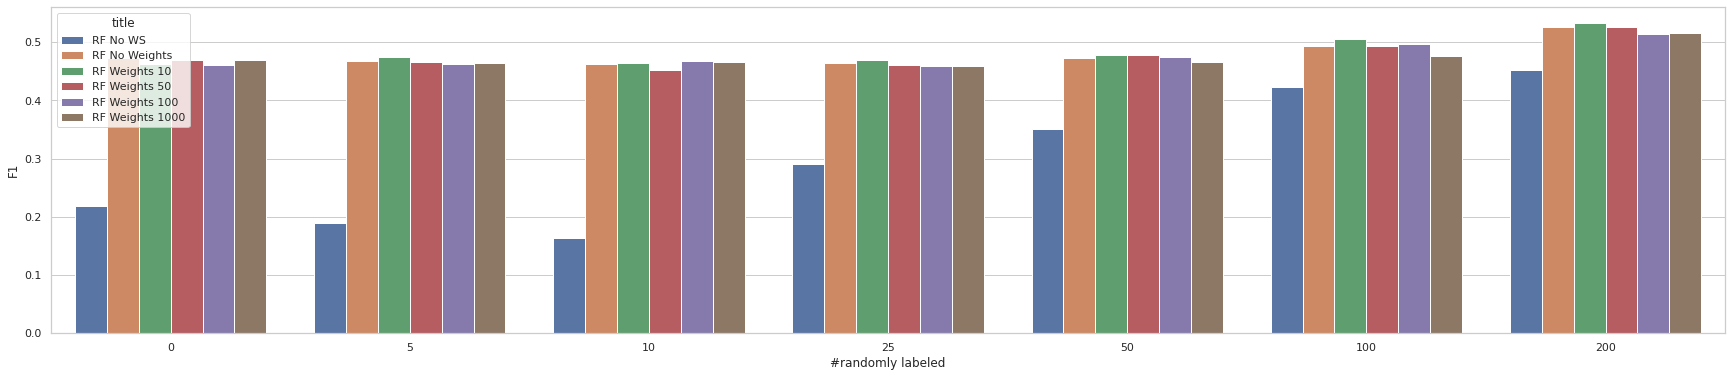

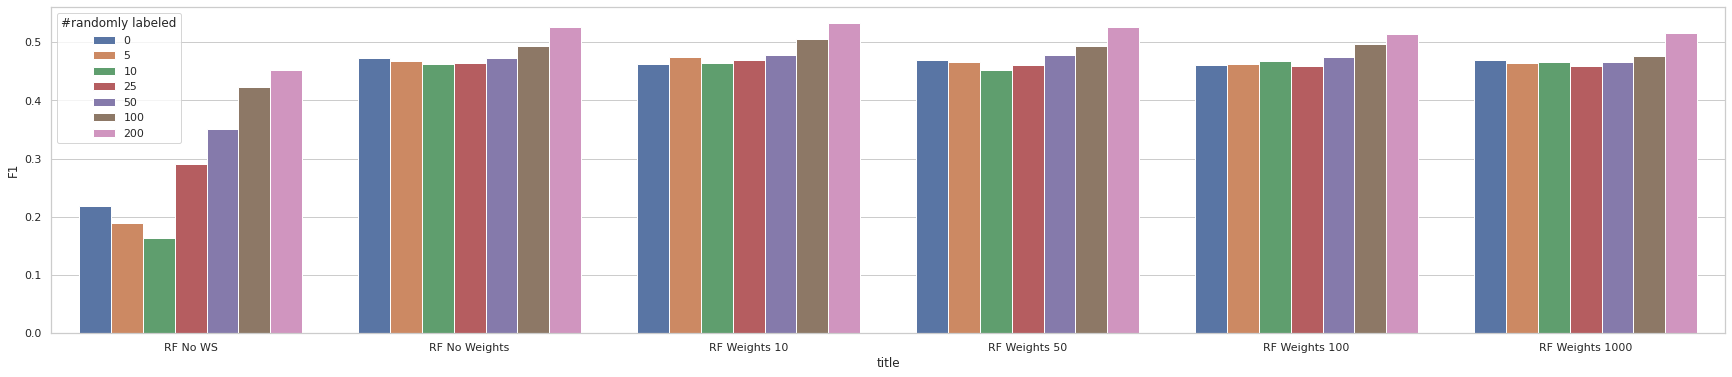

In [113]:
plt.figure(figsize=(30,6))
sns.barplot(data=random_df, x="#randomly labeled",   y="F1", hue="title")    

plt.figure(figsize=(30,6))
sns.barplot(data=random_df, hue="#randomly labeled", y="F1", x="title")    

In [ ]:
# -> how to combine AL and WS labels in a way, that the experiment actually benefits from the labels
# try out different WS labeling strategies
# 1. use potentially good samples based on Max-Margin instead of random ones
# 2. compute the 50/100/200/500 worst wrongly classified samples -> classify them correctly (aka. fake active learning) -> is there really room for improvement after falsely applyed WS??
# 3. snorkelize the LFs
# 4. als weitere labeling strategies abc

'''
parameter:

- Anzahl der Samples
- Prozent initial gelabelter Daten bevor WS dazu kommt
- Methode um verschiedene LFs zusammenzuführen (random, majority, snorkel)
- AL Samples Weight
- anzahl an LFs
- AL query strategy (random, mm, labels who are covered by the least amount of LFs, samples where LF classification is the most wrong, greatest disagremment among lfs)
- WS LF mit coverage + abstain betrachten
- qualität der LFs (viele schlechte, viele mittelmäßige, viele wirklich gute, etc.)
''' 

# wrong_mask = np.logical_not(np.array_equal(Y_pred, Y_true))

# print(data_storage.Y_merged_final[wrong_mask])
# print(data_storage.exp_Y[wrong_mask])
